In [1]:
# Cell 0: This Cell will serve to load any lybraries I will need throughout my project. This Helps me keep everything neat. 

# Basic data handling and computation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# PyTorch for model building and training
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Additional tools
import os  # For directory and file operations
import sys  # For system-specific parameters and functions


In [2]:
#Cell 1: Import new cleaned CSV

# Replace the file path with your specific file location
file_path = r'C:/Users/gsmit/OneDrive/Desktop/CS691 Project Codename Prayer/UDPLag.csv'
df = pd.read_csv(file_path)

# Display the first few rows to ensure it's loaded correctly
print(df.head())
print(df.info())


C:\Users\gsmit\AppData\Local\Temp\ipykernel_20156\43242056.py:5: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


   Unnamed: 0                                 Flow ID   Source IP  \
0       50880  172.16.0.5-192.168.50.4-35468-49856-17  172.16.0.5   
1       83164  172.16.0.5-192.168.50.4-44167-44225-17  172.16.0.5   
2       49389  172.16.0.5-192.168.50.4-36215-28771-17  172.16.0.5   
3       34687  172.16.0.5-192.168.50.4-44168-43679-17  172.16.0.5   
4       87466  172.16.0.5-192.168.50.4-52334-44960-17  172.16.0.5   

    Source Port  Destination IP   Destination Port   Protocol  \
0         35468    192.168.50.4              49856         17   
1         44167    192.168.50.4              44225         17   
2         36215    192.168.50.4              28771         17   
3         44168    192.168.50.4              43679         17   
4         52334    192.168.50.4              44960         17   

                    Timestamp   Flow Duration   Total Fwd Packets  ...  \
0  2018-11-03 11:01:43.652742              47                   2  ...   
1  2018-11-03 11:01:43.653107               2 

In [3]:
print(df.shape)

(725165, 88)


In [4]:
# Cell 2: Check if CUDA is available and set the device accordingly
# Specify the GPU device
if torch.cuda.is_available():
    print("Available CUDA devices:")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)} with {torch.cuda.get_device_properties(i).total_memory / 1e9} GB")
else:
    print("No CUDA devices available.")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")


Available CUDA devices:
Device 0: NVIDIA GeForce RTX 3050 Laptop GPU with 4.294508544 GB
Using cuda:0 device


       Unnamed: 0                                   Flow ID     Source IP  \
11647         472          255.255.255.255-0.0.0.0-67-68-17       0.0.0.0   
19990          66   192.168.50.9-87.250.250.119-39712-443-6  192.168.50.9   
30859         109  172.105.219.195-192.168.50.9-443-55460-6  192.168.50.9   
36908          51  172.105.219.195-192.168.50.9-443-55762-6  192.168.50.9   
42516          93   185.11.128.203-192.168.50.9-443-45916-6  192.168.50.9   

        Source Port   Destination IP   Destination Port   Protocol  \
11647            68  255.255.255.255                 67         17   
19990         39712   87.250.250.119                443          6   
30859         55460  172.105.219.195                443          6   
36908         55762  172.105.219.195                443          6   
42516         45916   185.11.128.203                443          6   

                        Timestamp   Flow Duration   Total Fwd Packets  ...  \
11647  2018-11-03 11:01:44.989964     

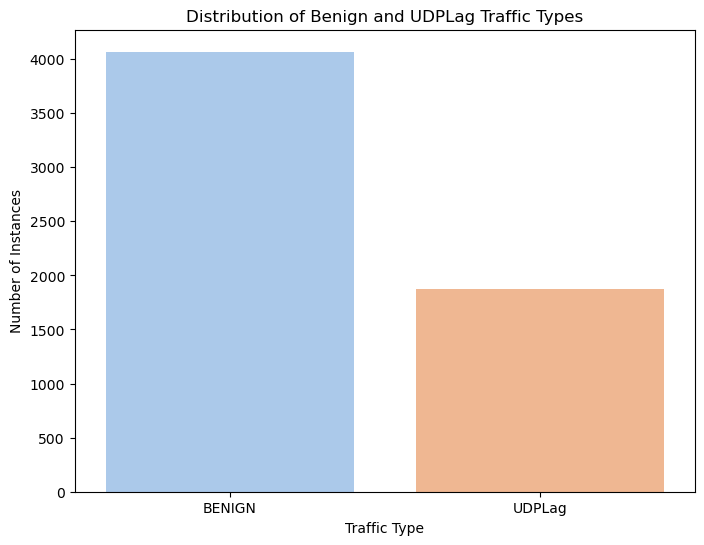

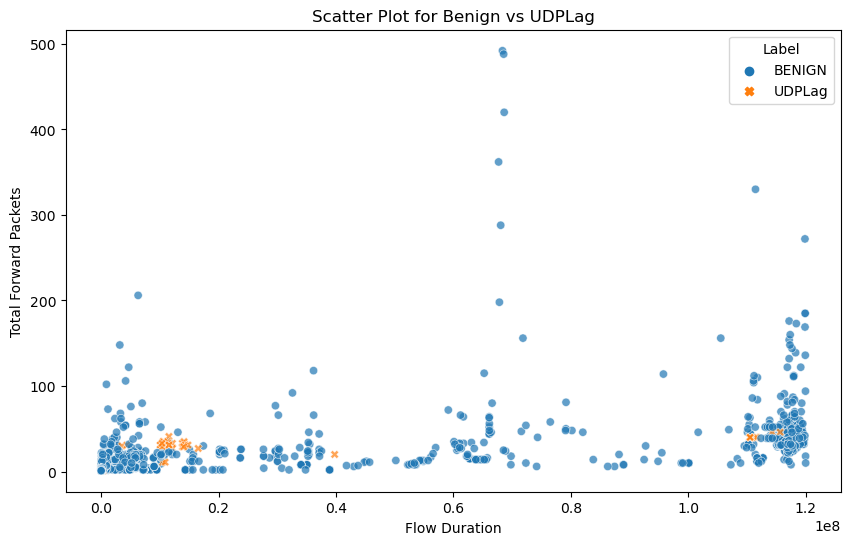

In [5]:
# Cell 3: Focus on Benign and UDPLag Data

# Filtering the DataFrame to include only Benign and UDPLag data
benign_udplag_df = df[df[' Label'].isin(['BENIGN', 'UDPLag'])]

# Display the first few rows to check the filtered data
print(benign_udplag_df.head())
print(f"Counts for Benign and UDPLag:\n{benign_udplag_df[' Label'].value_counts()}\n")

# Plot the distribution of the Benign and UDPLag classes
plt.figure(figsize=(8, 6))
sns.barplot(x=benign_udplag_df[' Label'].value_counts().index,
            y=benign_udplag_df[' Label'].value_counts().values,
            palette='pastel')
plt.title('Distribution of Benign and UDPLag Traffic Types')
plt.xlabel('Traffic Type')
plt.ylabel('Number of Instances')
plt.show()

# Select two continuous variables to compare
x_var = ' Flow Duration'
y_var = ' Total Fwd Packets'

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=benign_udplag_df, x=x_var, y=y_var, hue=' Label', style=' Label', alpha=0.7)
plt.title('Scatter Plot for Benign vs UDPLag')
plt.xlabel('Flow Duration')
plt.ylabel('Total Forward Packets')
plt.legend(title='Label')
plt.show()


C:\Users\gsmit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\gsmit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\gsmit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\gsmit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

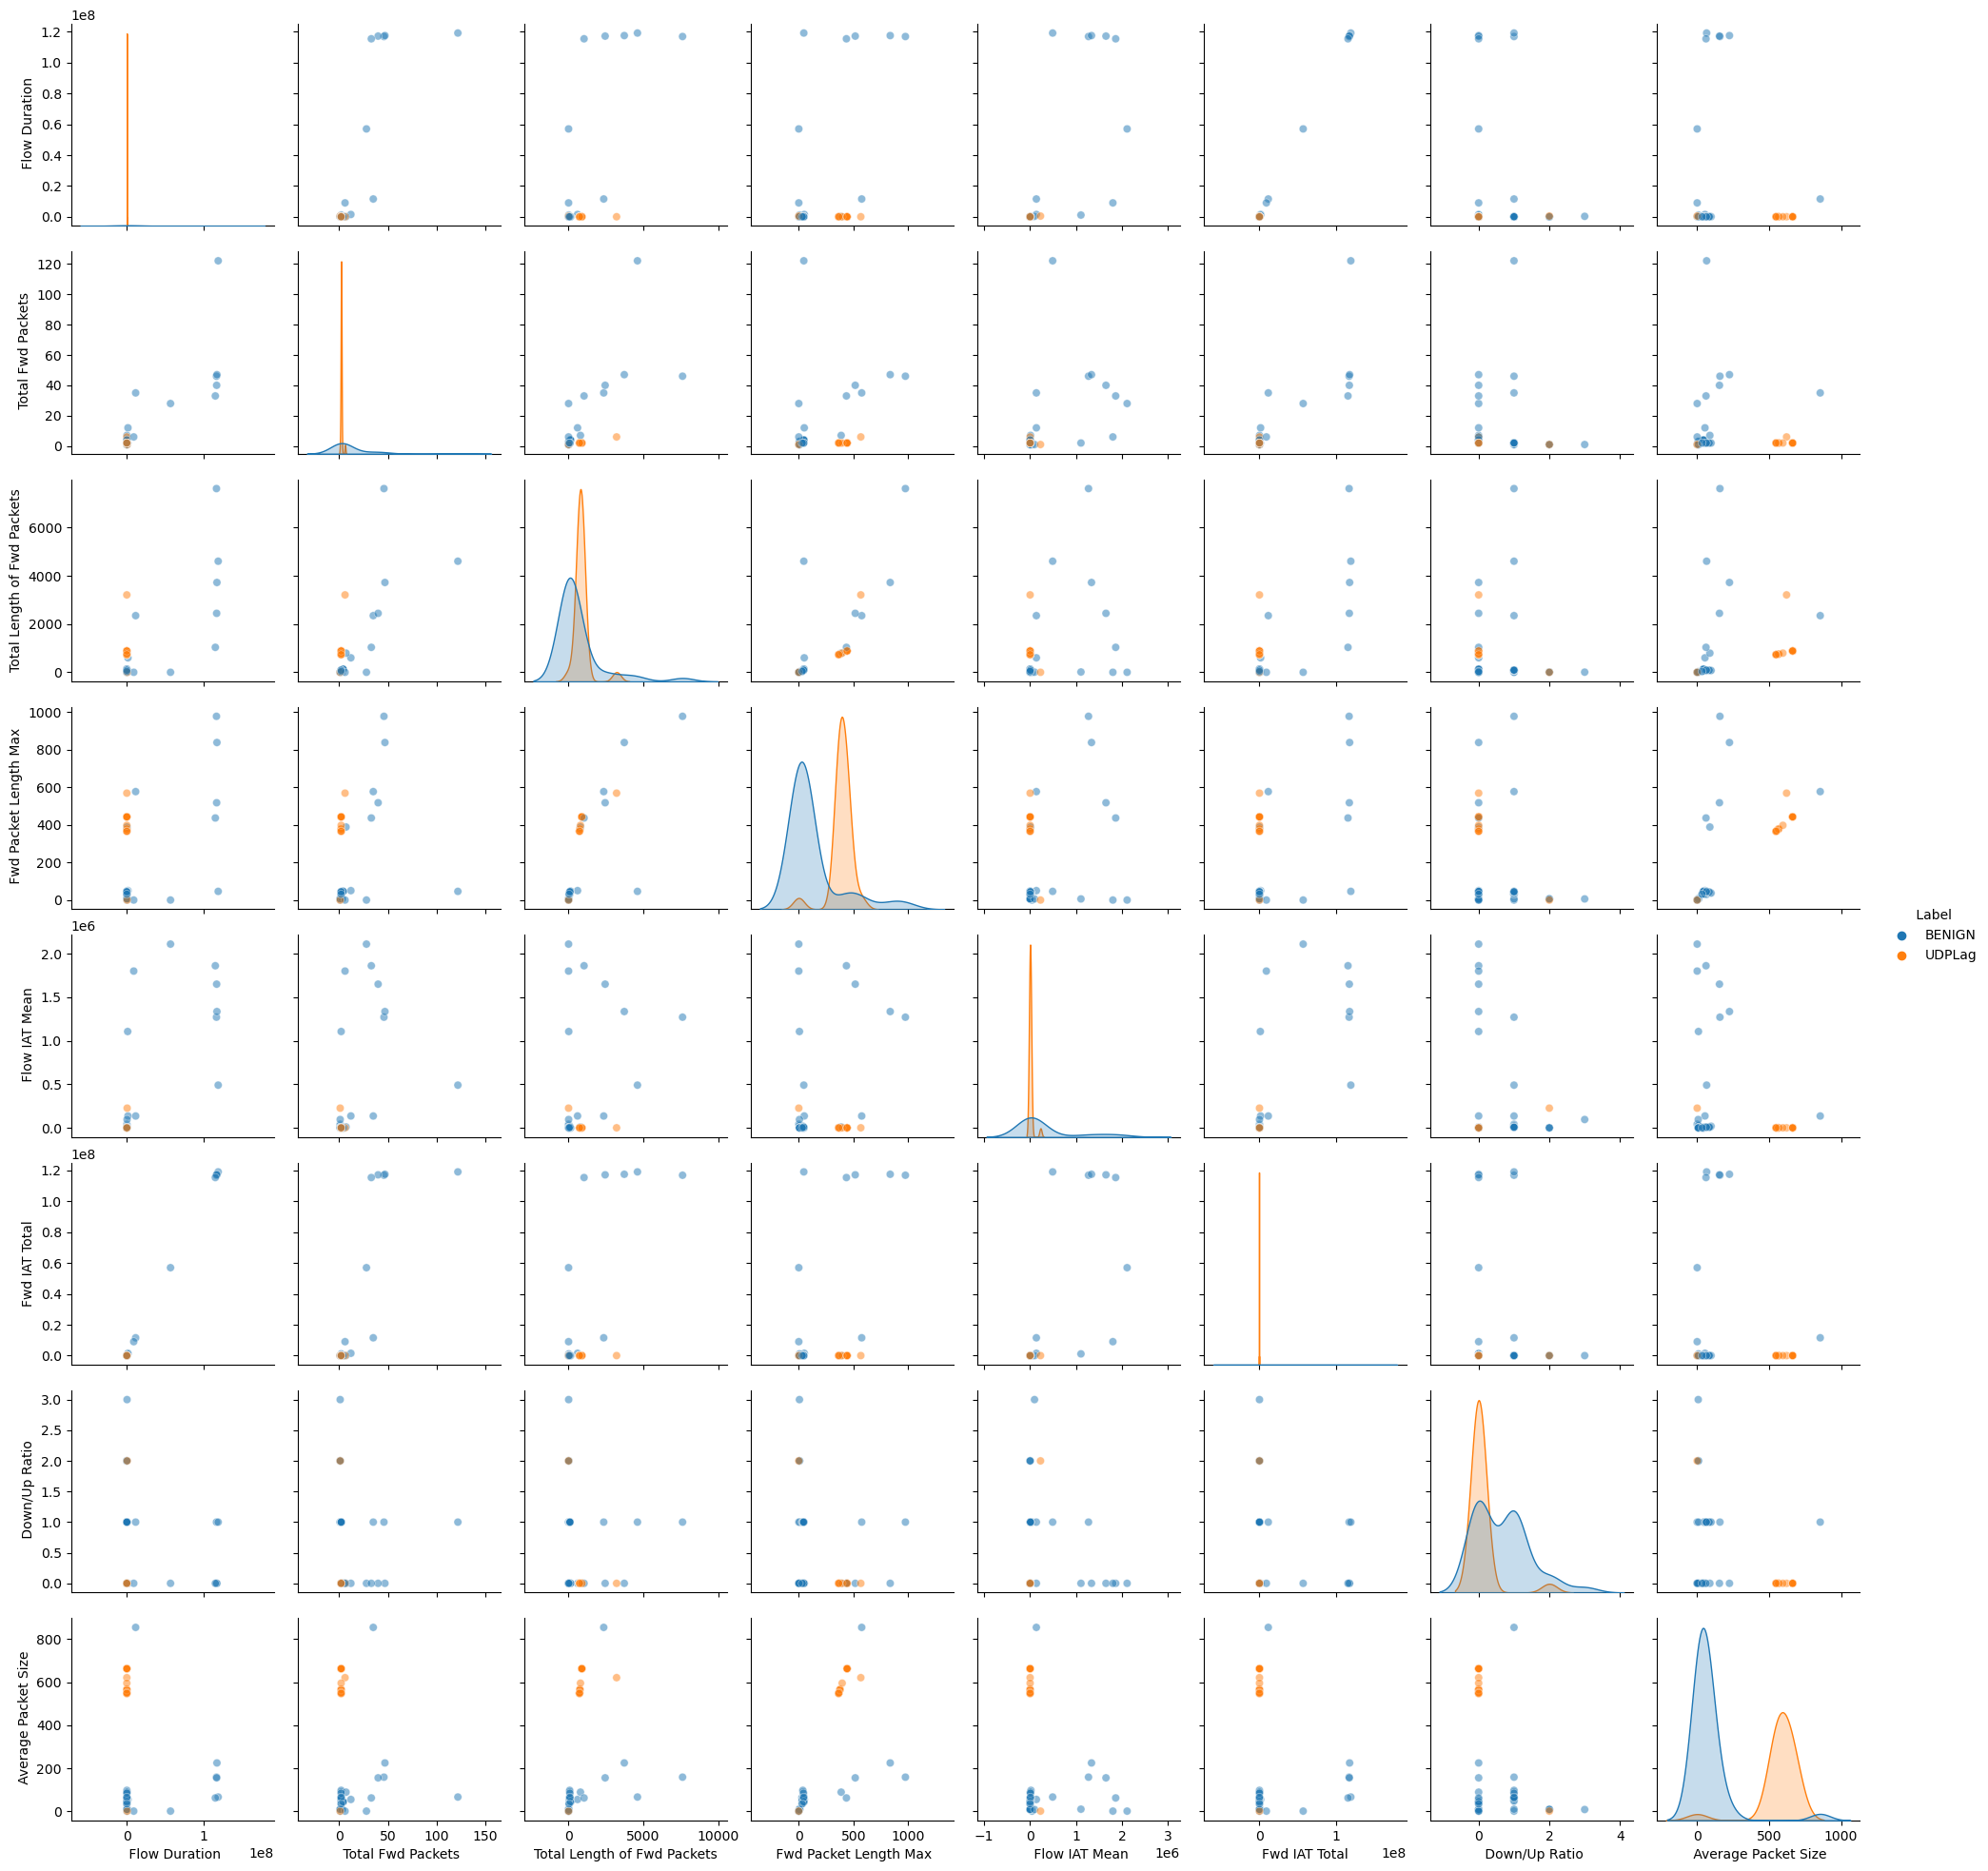

In [6]:
# Cell 5: Filter the data for 'Benign' and 'UDPLag'
filtered_df = benign_udplag_df.copy()

# Select a few features for the pair plot
selected_features = [
    ' Flow Duration',
    ' Total Fwd Packets',
    'Total Length of Fwd Packets',
    ' Fwd Packet Length Max',
    ' Flow IAT Mean',
    'Fwd IAT Total',
    ' Down/Up Ratio',
    ' Average Packet Size'
]

# Sample the data to make it more manageable for plotting
sampled_df = filtered_df.sample(frac=0.01, random_state=42)  # Adjust the fraction as needed

# Create a pair plot
sns.pairplot(sampled_df[selected_features + [' Label']], hue=' Label', plot_kws={'alpha': 0.5})

plt.show()

In [7]:
# Now using benign_udplag_df to ensure consistency.
print("Missing values per column:")
print(benign_udplag_df.isnull().sum())


Missing values per column:
Unnamed: 0         0
Flow ID            0
 Source IP         0
 Source Port       0
 Destination IP    0
                  ..
 Idle Max          0
 Idle Min          0
SimillarHTTP       0
 Inbound           0
 Label             0
Length: 88, dtype: int64


In [8]:
# Cell 7: List of columns to keep
columns_to_keep = [
    ' Source Port', ' Destination Port', ' Protocol', ' Flow Duration',
    ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets',
    ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min',
    ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max',
    ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std',
    'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std',
    ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean',
    ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total',
    ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min',
    'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count',
    ' ACK Flag Count', ' URG Flag Count', ' CWE Flag Count', ' ECE Flag Count',
    ' Down/Up Ratio', ' Average Packet Size', ' Avg Fwd Segment Size',
    ' Avg Bwd Segment Size', ' Label'
]
df_cleaned = filtered_df[columns_to_keep].copy()
print("DataFrame shape after removing erroneous entries:", df_cleaned.shape)


DataFrame shape after removing erroneous entries: (5941, 45)


In [9]:
# Cell 8: Ensure no negative values in 'Flow Duration' and ' Total Fwd Packets'
df_cleaned = df_cleaned[(df_cleaned[' Flow Duration'] >= 0) & (df_cleaned[' Total Fwd Packets'] >= 0)]
print("DataFrame shape after removing erroneous entries:", df_cleaned.shape)


DataFrame shape after removing erroneous entries: (5941, 45)


In [10]:
# Cell 9: Remove duplicates, handle infinities, and prepare for advanced imputation
df_cleaned = df_cleaned.drop_duplicates()
df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

# Add indicators for missing values for columns that will be imputed
for col in df_cleaned.columns:
    if df_cleaned[col].isnull().any():
        df_cleaned[col + '_missing'] = df_cleaned[col].isnull().astype(int)

print("Preparation complete. Ready for advanced imputation.")


Preparation complete. Ready for advanced imputation.


In [11]:
# Enable experimental features to use IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor

# Define the imputer
iterative_imputer = IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=5), random_state=42, max_iter=10)

# Columns selected for imputation
numeric_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
df_cleaned[numeric_cols] = iterative_imputer.fit_transform(df_cleaned[numeric_cols])

# Adding indicators for missing values for columns that will be imputed
for col in numeric_cols:
    if df_cleaned[col].isnull().any():
        df_cleaned[col + '_missing'] = df_cleaned[col].isnull().astype(int)

print("Missing values imputed using advanced techniques. Missing indicators added.")


Missing values imputed using advanced techniques. Missing indicators added.


C:\Users\gsmit\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [12]:
# Cell 11: Data Preparation for Model Training

# Adjust column names to ensure consistency
df_cleaned.columns = df_cleaned.columns.str.strip()

# Scale the features
scaler = StandardScaler()
features = df_cleaned.drop('Label', axis=1)
labels = df_cleaned['Label']

features_scaled = scaler.fit_transform(features)

# Encode the labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels_encoded, test_size=0.2, random_state=42)

# Convert training data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

# Convert test data to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

print("Features scaled, labels encoded, and data split into training and test sets. Tensors are ready for model training and evaluation.")

# Verify Label Encoding
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(df_cleaned['Label'])
# Print the mapping of labels to integers
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Label Encoding Mapping:", label_mapping)


Features scaled, labels encoded, and data split into training and test sets. Tensors are ready for model training and evaluation.
Label Encoding Mapping: {'BENIGN': 0, 'UDPLag': 1}


In [13]:
# Cell 12: Define the Neural Network Model for Binary Classification
class BasicNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(BasicNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(64, output_size)
        self.sigmoid = nn.Sigmoid()  # Only use if output_size == 1 for binary classification
        self.initialize_weights()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        if self.layer2.out_features == 1:  # Assuming binary classification
            x = self.sigmoid(x)
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


In [14]:
# Cell 13: Train the Neural Network
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# Define hyperparameters
learning_rate = 0.001
num_epochs = 50
batch_size = 64

# Prepare DataLoader for batch processing
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Initialize the model
model = BasicNN(input_size=X_train_tensor.shape[1], output_size=1)
model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # Suitable for binary classification with logits
optimizer = Adam(model.parameters(), lr=learning_rate)

# Training loop
model.train()
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [5/50], Loss: 0.5706
Epoch [10/50], Loss: 0.6319
Epoch [15/50], Loss: 0.6687
Epoch [20/50], Loss: 0.5829
Epoch [25/50], Loss: 0.6196
Epoch [30/50], Loss: 0.5706
Epoch [35/50], Loss: 0.6196
Epoch [40/50], Loss: 0.5829
Epoch [45/50], Loss: 0.5706
Epoch [50/50], Loss: 0.5706


Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.96      0.27      0.42       829
      UDPLag       0.32      0.97      0.48       299

    accuracy                           0.45      1128
   macro avg       0.64      0.62      0.45      1128
weighted avg       0.79      0.45      0.43      1128

Confusion Matrix:
[[221 608]
 [ 10 289]]


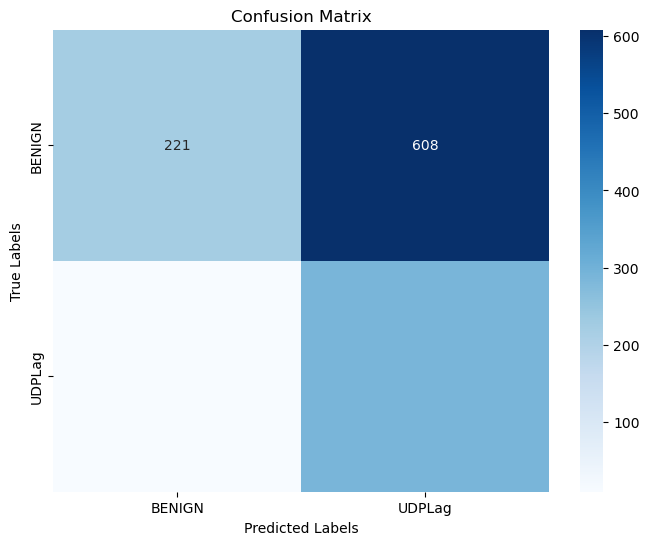

In [15]:
# Cell 14: Evaluate the Neural Network Model with Correct Labels
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Set the model to evaluation mode
model.eval()

# Prepare the DataLoader for the test data
test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Initialize lists to store true labels and predictions
predictions = []
true_labels = []

# No need to track gradients for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass to get outputs
        outputs = model(inputs)

        # Since outputs are logits, apply sigmoid to calculate probabilities
        probs = torch.sigmoid(outputs)

        # Convert probabilities to predicted classes
        preds = (probs > 0.5).int()

        # Store predictions and actual labels as numpy arrays
        predictions.append(preds.cpu().numpy())
        true_labels.append(labels.cpu().numpy())

# Concatenate all predictions and true labels from list of arrays
predictions = np.concatenate(predictions).flatten()
true_labels = np.concatenate(true_labels).flatten()

# Map numeric labels back to original labels using the encoder
predicted_labels = encoder.inverse_transform(predictions)
true_labels = encoder.inverse_transform(true_labels)

# Generate classification report and confusion matrix with actual label names
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=encoder.classes_))

print("Confusion Matrix:")
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

# Optionally, display the confusion matrix using Matplotlib for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [16]:
# Cell 15: Make a Copy of the Cleaned Data for Future Use
df2 = df_cleaned.copy()
print("A copy of the cleaned data has been made and stored in df2.")


A copy of the cleaned data has been made and stored in df2.


In [17]:
#Cell 16: Prepare Data for Random Forest Model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Ensure all column names have no leading or trailing spaces
df2.columns = df2.columns.str.strip()

# Separating the features and the target variable
X = df2.drop('Label', axis=1)
y = df2['Label'].values

# Encoding the labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print("Data prepared for Random Forest model.")


Data prepared for Random Forest model.


In [18]:
#Cell 17: Train Random Forest model

from sklearn.ensemble import RandomForestClassifier

# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

print("Random Forest model trained.")


Random Forest model trained.


Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00       829
      UDPLag       1.00      1.00      1.00       299

    accuracy                           1.00      1128
   macro avg       1.00      1.00      1.00      1128
weighted avg       1.00      1.00      1.00      1128

Confusion Matrix:
[[829   0]
 [  0 299]]
Accuracy Score:
1.0


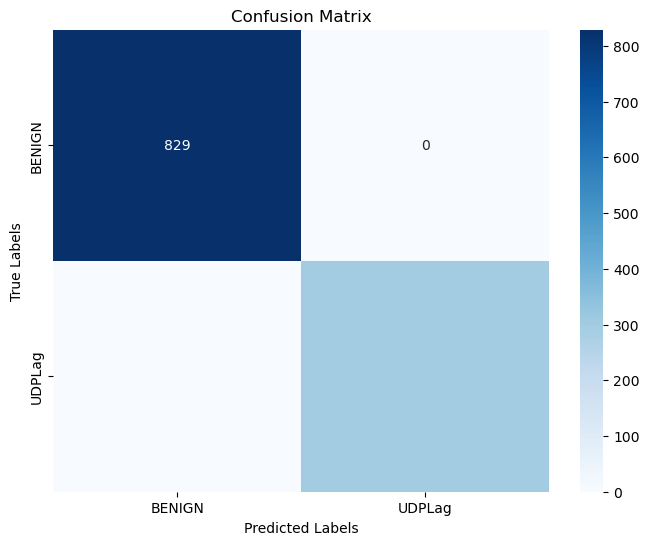

In [19]:
#Cell 18: Evaluate Random Forest Model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluating the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

# Optionally, display the confusion matrix using Matplotlib for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Fitting 3 folds for each of 324 candidates, totalling 972 fits


C:\Users\gsmit\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters found:  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best accuracy achieved:  0.9984484341010651
Optimized Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00       829
      UDPLag       1.00      1.00      1.00       299

    accuracy                           1.00      1128
   macro avg       1.00      1.00      1.00      1128
weighted avg       1.00      1.00      1.00      1128

Optimized Confusion Matrix:
[[829   0]
 [  1 298]]


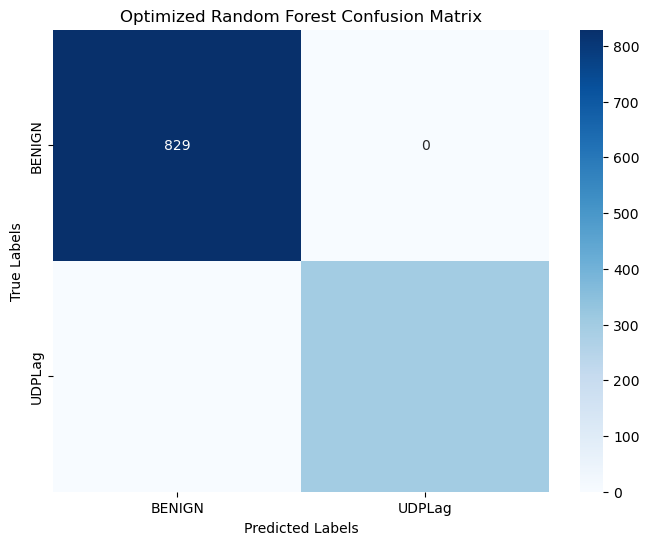

In [20]:
# Cell 19: Hypertunning RF
from sklearn.model_selection import GridSearchCV

# Setting up the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at every split
    'max_depth': [None, 10, 20, 30],  # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Create the base model to tune
rf = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy achieved: ", grid_search.best_score_)

# Rebuild the model with the best parameters
best_rf = grid_search.best_estimator_

# Evaluate on the test set
y_pred_optimized = best_rf.predict(X_test)
y_pred_labels_optimized = encoder.inverse_transform(y_pred_optimized)  # Decode the predictions
y_test_labels = encoder.inverse_transform(y_test)  # Decode y_test to use string labels for evaluation

print("Optimized Classification Report:")
print(classification_report(y_test_labels, y_pred_labels_optimized, target_names=encoder.classes_))

print("Optimized Confusion Matrix:")
cm = confusion_matrix(y_test_labels, y_pred_labels_optimized)
print(cm)

# Display the confusion matrix using Matplotlib for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Optimized Random Forest Confusion Matrix')
plt.show()


KNN Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.99      0.98      0.98       829
      UDPLag       0.95      0.96      0.96       299

    accuracy                           0.98      1128
   macro avg       0.97      0.97      0.97      1128
weighted avg       0.98      0.98      0.98      1128

KNN Confusion Matrix:
[[815  14]
 [ 12 287]]


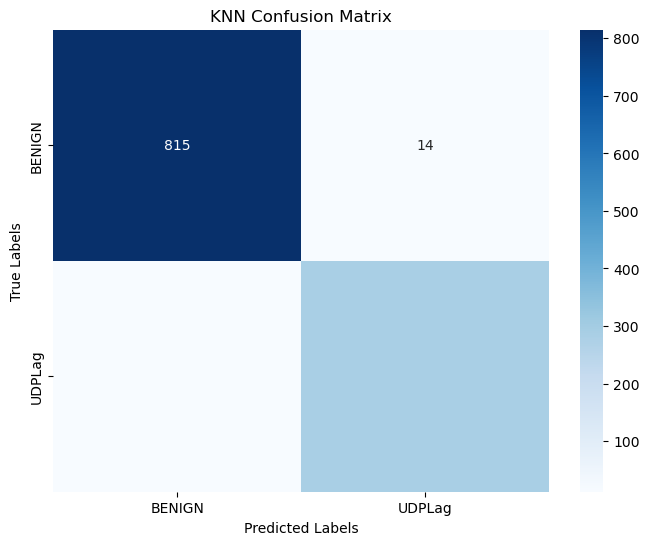

In [21]:
# Cell 20: Train K-Nearest Neighbors Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create and train the KNN classifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Making predictions on the test set
y_pred_knn = knn.predict(X_test)

# Decode the predictions and actual labels for reporting
y_pred_labels_knn = encoder.inverse_transform(y_pred_knn)
y_test_labels = encoder.inverse_transform(y_test)

print("KNN Classification Report:")
print(classification_report(y_test_labels, y_pred_labels_knn, target_names=encoder.classes_))
print("KNN Confusion Matrix:")
cm_knn = confusion_matrix(y_test_labels, y_pred_labels_knn)
print(cm_knn)

# Optionally, display the confusion matrix using Matplotlib for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('KNN Confusion Matrix')
plt.show()


In [22]:
#Cell 21: Hyperparameter Tuning for K-Nearest Neighbors
from sklearn.model_selection import GridSearchCV

# Setting up the parameter grid
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Different values for the number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metric for tree search
}

# Create the base model to tune
knn_base = KNeighborsClassifier()

# Instantiate the grid search model
knn_grid_search = GridSearchCV(estimator=knn_base, param_grid=knn_param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
knn_grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", knn_grid_search.best_params_)
print("Best accuracy achieved: ", knn_grid_search.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best accuracy achieved:  0.9822655221471951


Optimized KNN Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.99      0.98      0.99       829
      UDPLag       0.95      0.97      0.96       299

    accuracy                           0.98      1128
   macro avg       0.97      0.98      0.98      1128
weighted avg       0.98      0.98      0.98      1128

Optimized KNN Confusion Matrix:
[[815  14]
 [  8 291]]


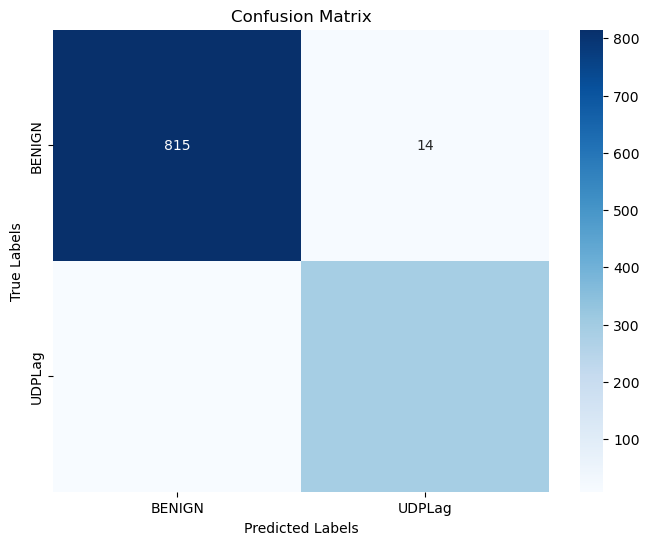

In [23]:
# Cell 22: Re-evaluate KNN with Optimized Parameters
from sklearn.metrics import classification_report, confusion_matrix

# Rebuild the model with the best parameters from hyperparameter tuning
best_knn = knn_grid_search.best_estimator_

# Evaluate on the test set
y_pred_optimized_knn = best_knn.predict(X_test)

# Decode the optimized predictions and actual labels for reporting
y_pred_labels_optimized_knn = encoder.inverse_transform(y_pred_optimized_knn)
y_test_labels = encoder.inverse_transform(y_test)

print("Optimized KNN Classification Report:")
print(classification_report(y_test_labels, y_pred_labels_optimized_knn, target_names=encoder.classes_))
print("Optimized KNN Confusion Matrix:")
cm_optimized_knn = confusion_matrix(y_test_labels, y_pred_labels_optimized_knn)
print(cm_optimized_knn)

# Optionally, display the confusion matrix using Matplotlib for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimized_knn, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Cell 23: Train and Evaluate SVM Model with a reduced dataset
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Reduce the training dataset size
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train, y_train, test_size=0.9, random_state=42)  # Use only 10% of data for initial training

# Create and train the SVM classifier on a reduced dataset
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train_sub, y_train_sub)

# Making predictions on the full test set
y_pred_svm = svm_classifier.predict(X_test)

# Decode the predictions for reporting
y_pred_labels_svm = encoder.inverse_transform(y_pred_svm)

# Evaluating the model
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_labels_svm, target_names=encoder.classes_))

print("SVM Confusion Matrix:")
cm_svm = confusion_matrix(y_test, y_pred_labels_svm)
print(cm_svm)

# Display the confusion matrix using Matplotlib for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('SVM Confusion Matrix')
plt.show()

In [ ]:
# Cell 24: Hyperparameter Tuning for Support Vector Machine
from sklearn.model_selection import GridSearchCV

# Setting up the parameter grid
svm_param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 1, 10, 100],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'kernel': ['rbf', 'poly', 'sigmoid']  # Specifies the kernel type to be used in the algorithm
}

# Create the base model to tune
svm_base = SVC(random_state=42)

# Instantiate the grid search model
svm_grid_search = GridSearchCV(estimator=svm_base, param_grid=svm_param_grid, cv=3, n_jobs=-1, verbose=2,
                               scoring='accuracy')

# Fit the grid search to the data
svm_grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", svm_grid_search.best_params_)
print("Best accuracy achieved: ", svm_grid_search.best_score_)

# Cell 25: Re-evaluate SVM with Optimized Parameters
best_svm = svm_grid_search.best_estimator_

# Evaluate on the test set
y_pred_optimized_svm = best_svm.predict(X_test)
y_pred_labels_optimized_svm = encoder.inverse_transform(y_pred_optimized_svm)

print("Optimized SVM Classification Report:")
print(classification_report(y_test, y_pred_labels_optimized_svm, target_names=encoder.classes_))
print("Optimized SVM Confusion Matrix:")
cm_optimized_svm = confusion_matrix(y_test, y_pred_labels_optimized_svm)
print(cm_optimized_svm)

# Display the confusion matrix using Matplotlib for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimized_svm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Optimized SVM Confusion Matrix')
plt.show()


In [ ]:
# Cell 25: Re-evaluate SVM with Optimized Parameters

# Rebuild the model with the best parameters
best_svm = svm_grid_search.best_estimator_

# Evaluate on the test set
y_pred_optimized_svm = best_svm.predict(X_test)
y_pred_labels_optimized_svm = encoder.inverse_transform(y_pred_optimized_svm)  # Decode labels

# Evaluating the model
print("Optimized SVM Classification Report:")
print(classification_report(y_test, y_pred_labels_optimized_svm, target_names=encoder.classes_))

print("Optimized SVM Confusion Matrix:")
cm_optimized_svm = confusion_matrix(y_test, y_pred_labels_optimized_svm)
print(cm_optimized_svm)

# Display the confusion matrix using Matplotlib for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimized_svm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Optimized SVM Confusion Matrix')
plt.show()
